In [1]:
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
import os
import cv2
import random

In [7]:
from mtcnn import MTCNN

In [8]:
dataset_path="C:/Users/91812/Downloads/archive (4)"


In [9]:
attributes_path=os.path.join(dataset_path,"list_attr_celeba.csv")

In [10]:
attributes_df = pd.read_csv(attributes_path)
print("Attribute DataFrame Shape:", attributes_df.shape)
print("Column Names:", attributes_df.columns)

Attribute DataFrame Shape: (202599, 41)
Column Names: Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


In [11]:
images_path = os.path.join(dataset_path, "img_align_celeba","img_align_celeba")

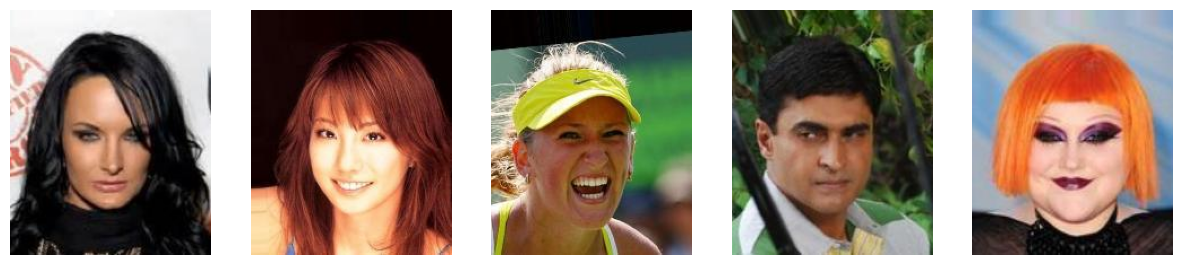

In [12]:
image_files = os.listdir(images_path)


fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img_path = os.path.join(images_path, random.choice(image_files))
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

In [13]:
partition_path = os.path.join(dataset_path, "list_eval_partition.csv")


In [14]:
partition_df = pd.read_csv(partition_path)
print("\n Partition DataFrame Shape:", partition_df.shape)
print(" First Few Rows:")
print(partition_df.head())


 Partition DataFrame Shape: (202599, 2)
 First Few Rows:
     image_id  partition
0  000001.jpg          0
1  000002.jpg          0
2  000003.jpg          0
3  000004.jpg          0
4  000005.jpg          0


In [15]:
from mtcnn import MTCNN

In [16]:
def detect_and_align_faces(image_path, save_path):
    detector = MTCNN(device='/cpu:0')
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)
    
    if faces:
        x, y, width, height = faces[0]['box']
        aligned_face = img_rgb[y:y+height, x:x+width]
        cv2.imwrite(save_path, cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR))
        return True
    return False

In [17]:
aligned_images_path = os.path.join(dataset_path, "aligned_faces")
if not os.path.exists(aligned_images_path):
    os.makedirs(aligned_images_path)


In [18]:

processed_count = 0
for image_file in image_files[:1000]: 
    input_path = os.path.join(images_path, image_file)
    output_path = os.path.join(aligned_images_path, image_file)
    if detect_and_align_faces(input_path, output_path):
        processed_count += 1

print(f"Processed {processed_count} faces and saved them in {aligned_images_path}")

Processed 995 faces and saved them in C:/Users/91812/Downloads/archive (4)\aligned_faces


In [24]:
from mtcnn import MTCNN

detector = MTCNN()
print("MTCNN loaded successfully!")


MTCNN loaded successfully!


In [25]:
import sys
print(sys.executable)

c:\Users\91812\anaconda3\python.exe


In [26]:
from deepface import DeepFace

In [27]:
embedding_dict={}

In [30]:
for image_file in os.listdir(aligned_images_path):
    img_path=os.path.join(aligned_images_path,image_file)
    try:
        embedding=DeepFace.represent(img_path=img_path,model_name='Facenet')[0]['embedding']
        embedding_dict[image_file]=embedding
    except Exception as e:
        print(f" Failed to extract embedding for {image_file}: {e}")
    
print(f" Extracted embeddings for {len(embedding_dict)} aligned faces")


 Failed to extract embedding for 000003.jpg: Face could not be detected in C:/Users/91812/Downloads/archive (4)\aligned_faces\000003.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
 Failed to extract embedding for 000004.jpg: Face could not be detected in C:/Users/91812/Downloads/archive (4)\aligned_faces\000004.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
 Failed to extract embedding for 000060.jpg: Face could not be detected in C:/Users/91812/Downloads/archive (4)\aligned_faces\000060.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
 Failed to extract embedding for 000070.jpg: Face could not be detected in C:/Users/91812/Downloads/archive (4)\aligned_faces\000070.jpg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.
 Failed to extract embedding for 000086.jpg: Fac

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
image_names=list(embedding_dict.keys())
embedding_matrix=np.array([embedding_dict[name] for name in image_names])

In [33]:
similarity_matrix=cosine_similarity(embedding_matrix)


In [34]:
top_matches={}

In [36]:
for idx , name in enumerate(image_names):
    similarities=similarity_matrix[idx]
    sorted_indices=np.argsort(similarities)[::-1]
    top_match_index=sorted_indices[1]
    top_matches[name]=image_names[top_match_index]


In [37]:
def match_celebrity(input_image_path):
    try:
        input_embedding = DeepFace.represent(img_path=input_image_path, model_name='Facenet')[0]["embedding"]
        input_embedding = np.array(input_embedding).reshape(1, -1)
        similarities = cosine_similarity(input_embedding, embedding_matrix)[0]
        top_index = np.argmax(similarities)
        matched_image_name = image_names[top_index]
        return matched_image_name, similarities[top_index]
    except Exception as e:
        print(f" Matching failed: {e}")
        return None, None


In [46]:
matched_image, score = match_celebrity("C:/Users/91812/Downloads/resume photo.jpg")
print(f"Best match: {matched_image} with similarity score {score}")

Best match: 000511.jpg with similarity score 0.4326145859986553


In [51]:
matched_image_path = os.path.join(aligned_images_path, matched_image)


In [ ]:
matched_image_path

'C:/Users/91812/Downloads/archive (4)\\aligned_faces\\000511.jpg'

In [ ]:
img_matched=cv2.imread(matched_image_path)

In [ ]:
plt.imshow(img_matched)